In [1]:
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import torch
import torchvision.ops as ops

from src.data_modules.detection_data_module import CbisDdsmDataModuleDetection
from src.models.detection_model import DetectionModel

In [2]:
datamodule = CbisDdsmDataModuleDetection(
    root_dir="data/cbis-ddsm-detec",
    tumor_type="mass",
    batch_size=1,
    num_workers=4,
)

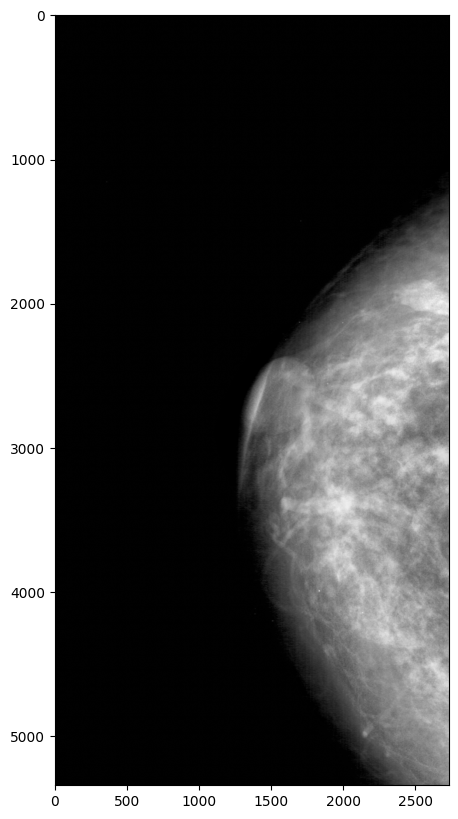

In [3]:
for batch in datamodule.train_dataloader():
    x, y = batch[0][0], batch[1][0]

    image = x.squeeze().numpy()

    fig, ax = plt.subplots(1, figsize=(10, 10))
    ax.imshow(image, cmap="gray")

    boxes = y["boxes"]
    for i in range(0, len(boxes)):
        xmin, ymin = boxes[i][0], boxes[i][1]
        xmax, ymax = boxes[i][2], boxes[i][3]

        rect = patches.Rectangle(
            (xmin, ymin),
            xmax - xmin,
            ymax - ymin,
            linewidth=1,
            edgecolor="r",
            facecolor="none",
        )

        ax.add_patch(rect)

    plt.show()
    break

In [4]:
model = DetectionModel(weight_path="models/mass-detection.ckpt")
model = model.eval()

Loaded weights from models/mass-detection.ckpt


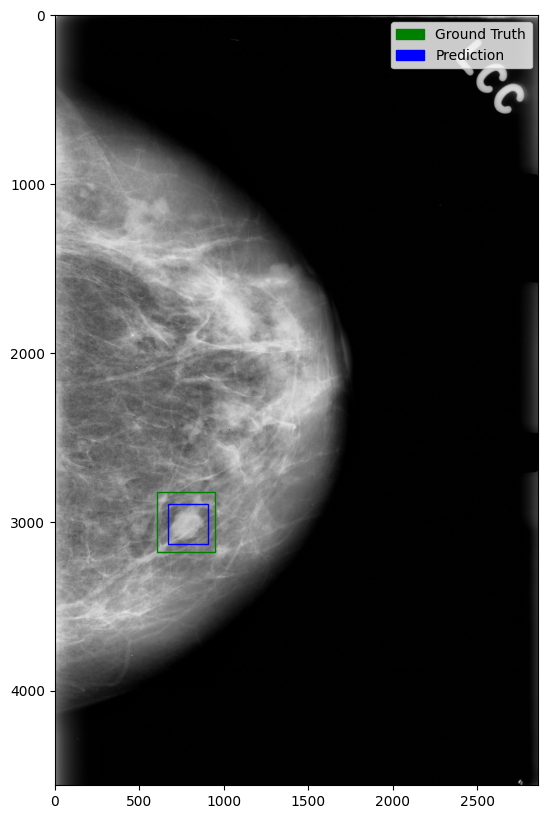

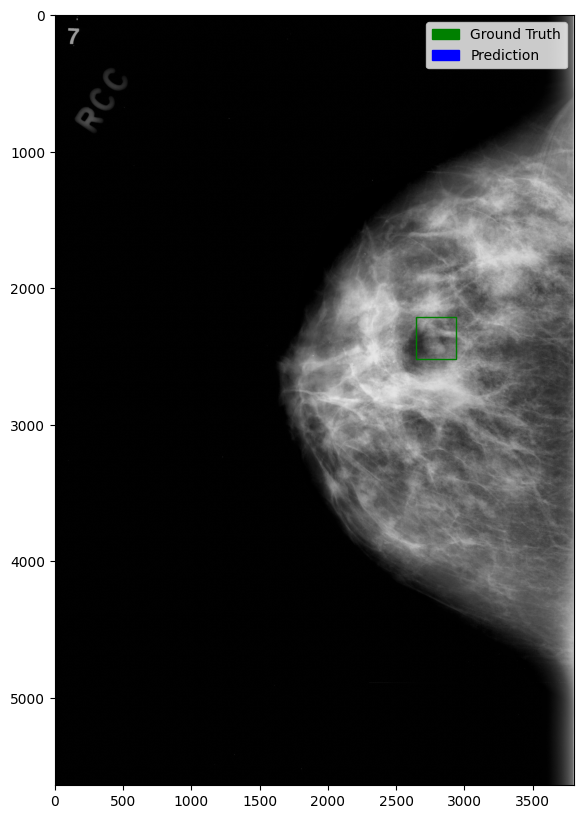

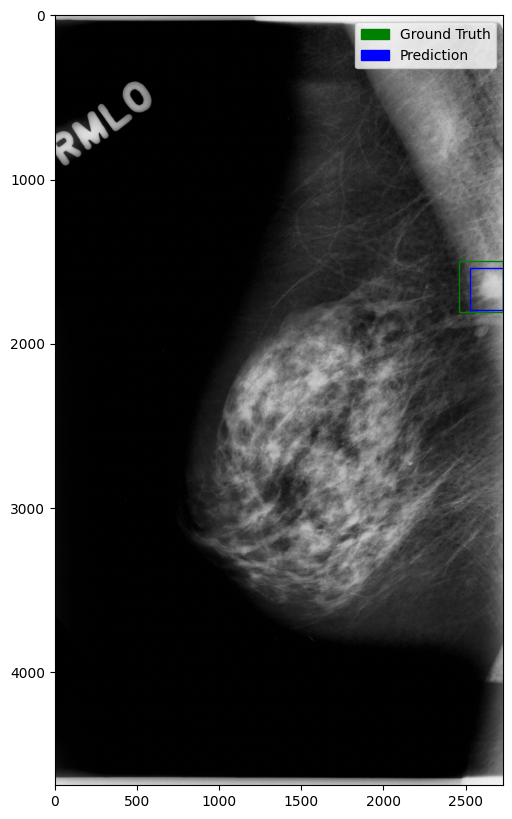

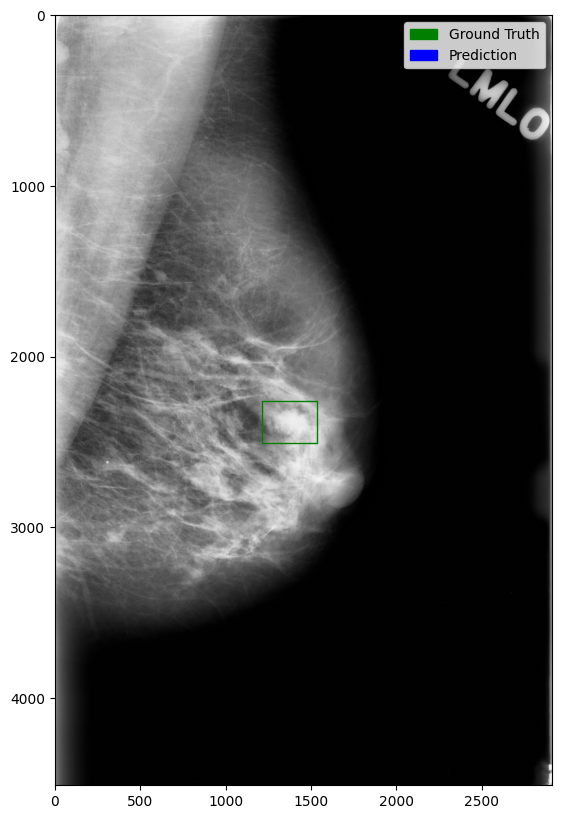

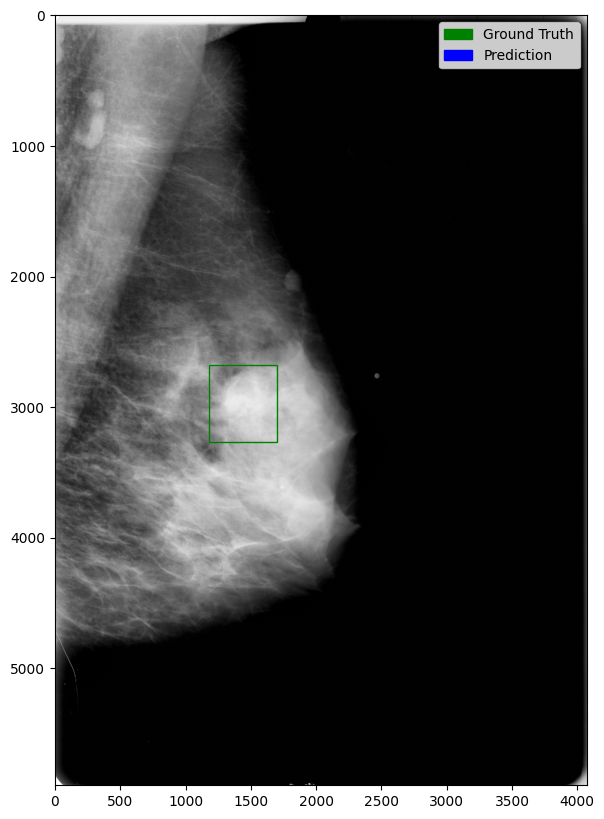

In [5]:
# Get a validation batch
for idx, batch in enumerate(datamodule.val_dataloader()):
    if idx == 5:
        break

    x, y = batch[0][0], batch[1][0]

    # Prepare the image
    image = x.squeeze().numpy()

    # Get ground truth boxes
    ground_truth_boxes = y["boxes"]

    # Get model predictions
    model.eval()
    with torch.no_grad():
        predictions = model(x.unsqueeze(0))
    confidence_threshold = 0.7
    scores = predictions[0]["scores"]
    boxes = predictions[0]["boxes"]
    predicted_boxes = boxes[scores > confidence_threshold]

    iou_threshold = 0.3
    keep_indices = ops.nms(
        predicted_boxes,
        scores[scores > confidence_threshold],
        iou_threshold,
    )

    # Filtered results
    filtered_boxes = predicted_boxes
    filtered_scores = scores[scores > confidence_threshold][keep_indices]

    # Plot the image
    fig, ax = plt.subplots(1, figsize=(10, 10))
    ax.imshow(image, cmap="gray")

    # Plot ground truth boxes in green
    for box in ground_truth_boxes:
        xmin, ymin, xmax, ymax = box
        rect = patches.Rectangle(
            (xmin, ymin),
            xmax - xmin,
            ymax - ymin,
            linewidth=1,
            edgecolor="g",
            facecolor="none",
            label="Ground Truth",
        )
        ax.add_patch(rect)

    # Plot predicted boxes in blue
    for box in filtered_boxes:
        xmin, ymin, xmax, ymax = box
        rect = patches.Rectangle(
            (xmin, ymin),
            xmax - xmin,
            ymax - ymin,
            linewidth=1,
            edgecolor="b",
            facecolor="none",
            label="Prediction",
        )
        ax.add_patch(rect)

    plt.legend(
        handles=[
            patches.Patch(color="green", label="Ground Truth"),
            patches.Patch(color="blue", label="Prediction"),
        ]
    )
    plt.show()